In [1]:
import numpy as np
import pickle
import lzma

import elephant.statistics as estats
import elephant
import neo
from quantities import ms, s, Hz

from elephant.spike_train_dissimilarity import victor_purpura_distance
from elephant.spike_train_dissimilarity import van_rossum_distance

import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing



In [2]:

def get_vpdist(networktype, layercount, meandelay, stddelay, model_id, input_idx, n_run, CellType = "point"):
    name = networktype + '_' + str(CellType) + '_layercount' + str(layercount) + '_model' + str(model_id) + '_input' + str(input_idx) + '_stddelay' + str(stddelay) + '_meandelay' + str(meandelay) + '_nrun' + str(n_run)
    with lzma.open("./VP_every/" + name + "_vp.xz", "rb") as fp:
          outsaved = pickle.load(fp)
    return outsaved
        
def get_vrdist(networktype, layercount, meandelay, stddelay, model_id, input_idx, n_run, CellType = "point"):
    name = networktype + '_' + str(CellType) + '_layercount' + str(layercount) + '_model' + str(model_id) + '_input' + str(input_idx) + '_stddelay' + str(stddelay) + '_meandelay' + str(meandelay) + '_nrun' + str(n_run)
    with lzma.open("./VR_every/" + name + "_vr.xz", "rb") as fp:
          outsaved = pickle.load(fp)
    return outsaved


In [3]:
# networktype = 'FeedForward'
# CellType = 'point'

# std_delay_lst = []
# for stdDelay_noround in np.arange(0.1, 1.01, 0.1):
#     stdDelay = np.round(stdDelay_noround,2)
#     std_delay_lst.append(stdDelay)

# mean_delay_lst = []
# for MeanDelay_noround in np.arange(2, 3.01, 0.2):
#     MeanDelay = np.round(MeanDelay_noround,1)
#     mean_delay_lst.append(MeanDelay)

# counter = 0
# alloutsaved = []
# for layercount in [30, 40, 50, 60]:
#     for MeanDelay in mean_delay_lst:
#         for stddelay in std_delay_lst:
#             for modelid in range(10):
#                 for inputid in range(10):
#                     for nrun in range(10):    
#                         outsaved = pd.DataFrame(get_vpdist(networktype, layercount, MeanDelay, stddelay, modelid, inputid, nrun, CellType))
#                         outsaved.columns = {'avgVP', 'SpikeCountatBase', 'Layer#'}
#                         outsaved['avgVP'] = outsaved['avgVP'].astype('float64')
#                         outsaved['SpikeCountatBase'] = outsaved['avgVP'].astype('int')
#                         outsaved['Layer#'] = outsaved['avgVP'].astype('int')
#                         outsaved['layercount'] = layercount
#                         outsaved['stddelay'] = stddelay
#                         outsaved['MeanDelay'] = MeanDelay
#                         outsaved['modelid'] = modelid
#                         outsaved['inputid'] = inputid
#                         outsaved['nrun'] = nrun
#                         alloutsaved.append(outsaved)
#                         if counter % 1000 == 0 :
#                             print(counter)
#                         counter += 1
                        
# combined_df = pd.concat(alloutsaved, axis=0, ignore_index=True)

# with lzma.open("./VPofEveryCellEveryRun.xz", "wb") as fp:
#     pickle.dump(combined_df, fp)

In [4]:
# with lzma.open("./VPofEveryCellEveryRun_30.xz", "rb") as fp:
#     combined_df_30 = pickle.load(fp)
# with lzma.open("./VPofEveryCellEveryRun_40.xz", "rb") as fp:
#     combined_df_40 = pickle.load(fp)
# with lzma.open("./VPofEveryCellEveryRun_50.xz", "rb") as fp:
#     combined_df_50 = pickle.load(fp)
# with lzma.open("./VPofEveryCellEveryRun_60.xz", "rb") as fp:
#     combined_df_60 = pickle.load(fp)
# combined_df = pd.concat([combined_df_30, combined_df_40, combined_df_50, combined_df_60])
# with lzma.open("./VPofEveryCellEveryRun.xz", "wb") as fp:
#     pickle.dump(combined_df, fp)


In [5]:
# networktype = 'FeedForward'
# CellType = 'point'
# get_vpdist(networktype, 60, 2.8, 0.8, 5, 5, 5, CellType)

In [6]:
with lzma.open("./VPofEveryCellEveryRun.xz", "rb") as fp:
    combined_df = pickle.load(fp)

In [7]:
grouped_df = combined_df.groupby(['layercount', 'MeanDelay', 'stddelay', 'Layer#']).mean()['avgVP']
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.rename(columns={
    'layercount': 'LayerCount',
    'MeanDelay': 'MeanDelay',  # This renaming is redundant but included for clarity
    'stddelay': 'StdDelay',
    'Layer#': 'NthLayer',
    'avgVP': 'VP'  # Renaming the aggregated column to 'VP'
})

ValueError: x and y must have same first dimension, but have shapes (21,) and (10,)

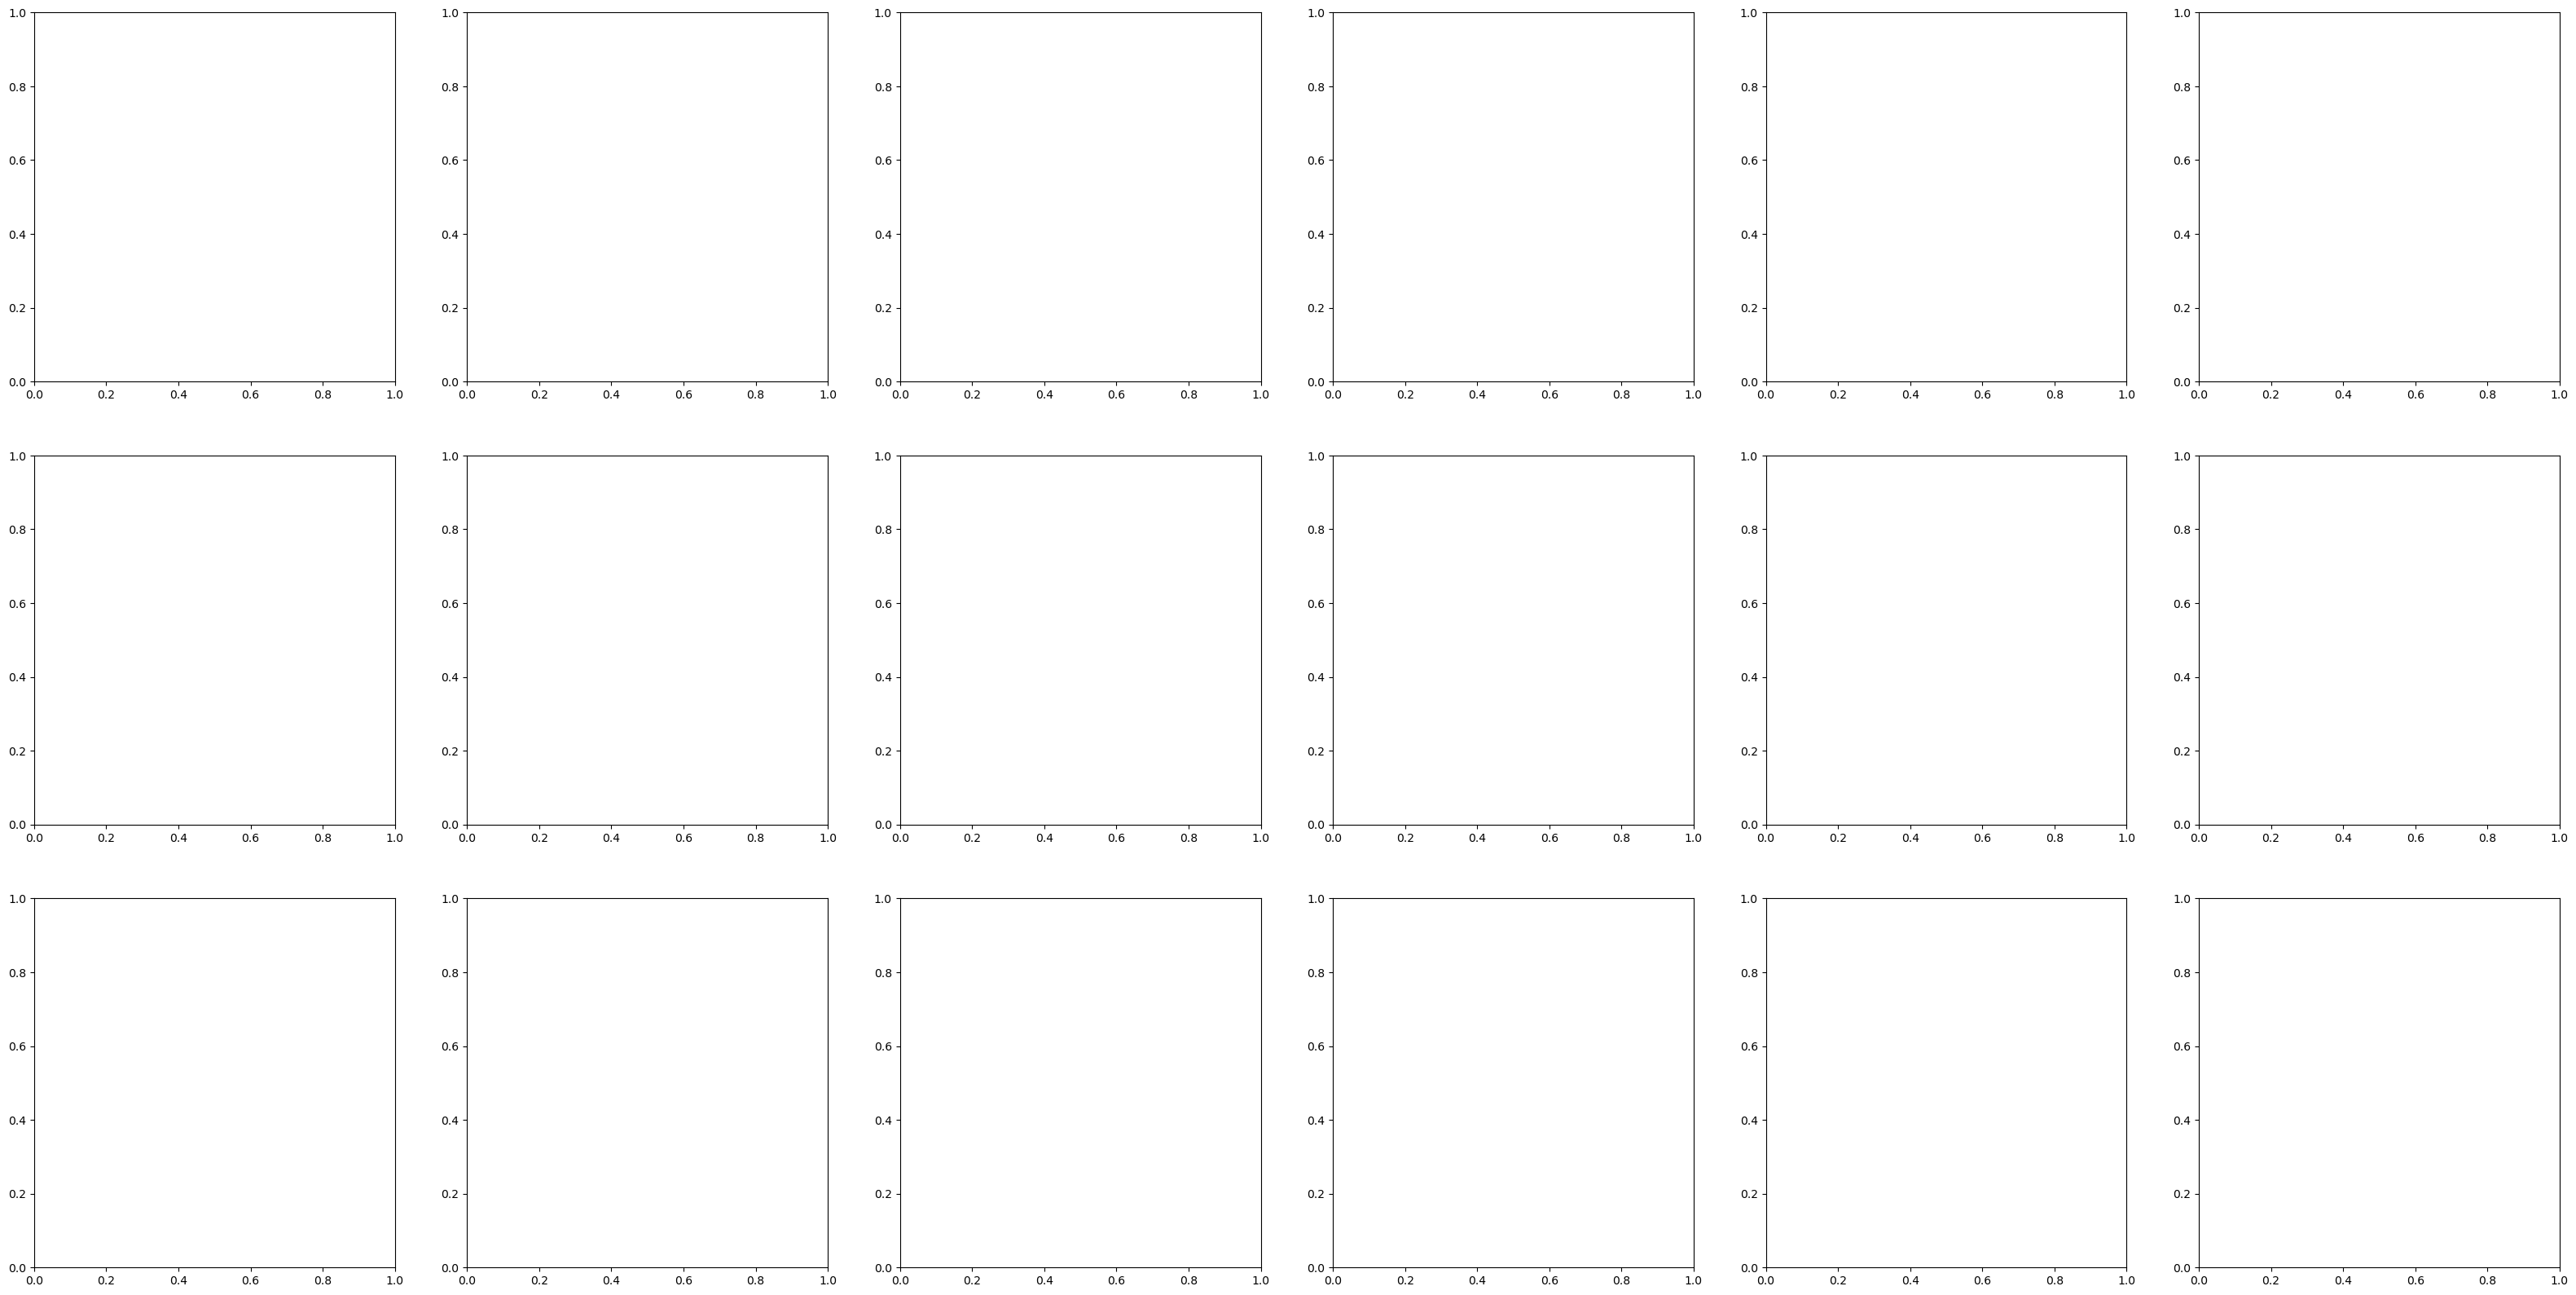

In [9]:
df = grouped_df
std_delay_lst = []
for stdDelay_noround in np.arange(0.0, 1.01, 0.05):
        stdDelay = np.round(stdDelay_noround,2)
        std_delay_lst.append(stdDelay)

# for cost = 0/ms but missing is 1
fig, axs = plt.subplots(3, 6, figsize=(40, 20))
counter_i = -1
for layercount in [30, 40, 50, 60]:
    counter_i += 1 
    counter_j = -1
    for MeanDelay_noround in np.arange(2, 3.01, 0.2):
        MeanDelay = np.round(MeanDelay_noround,1)
        counter_j += 1
        for nlayer in np.arange(0, 10):
            # y = df.loc[(df['LayerCount'] == layercount) & (df['MeanDelay'] == MeanDelay) & (df['NthLayer'] == nlayer), 'VP'].values[0]
            y = df.loc[(df['LayerCount'] == layercount) & (df['MeanDelay'] == MeanDelay) & (df['NthLayer'] == nlayer), :].sort_values(by ='StdDelay')['VP']
            axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlayer) + ' layers')
            axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(layercount, MeanDelay))
            axs[counter_i, counter_j].legend()

In [ ]:
with lzma.open("./VRofEveryCellEveryRun.xz", "rb") as fp:
    combined_df = pickle.load(fp)

In [ ]:
grouped_df = combined_df.groupby(['layercount', 'MeanDelay', 'stddelay', 'Layer#']).mean()['avgVR']
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.rename(columns={
    'layercount': 'LayerCount',
    'MeanDelay': 'MeanDelay',  # This renaming is redundant but included for clarity
    'stddelay': 'StdDelay',
    'Layer#': 'NthLayer',
    'avgVR': 'VR'  # Renaming the aggregated column to 'VP'
})

In [ ]:
df = grouped_df
std_delay_lst = []
for stdDelay_noround in np.arange(0.0, 1.01, 0.05 ):
        stdDelay = np.round(stdDelay_noround,2)
        std_delay_lst.append(stdDelay)

# for cost = 0/ms but missing is 1
fig, axs = plt.subplots(3, 6, figsize=(40, 20))
counter_i = -1
for layercount in [30, 40, 50, 60]:
    counter_i += 1 
    counter_j = -1
    for MeanDelay_noround in np.arange(2, 3.01, 0.2):
        MeanDelay = np.round(MeanDelay_noround,1)
        counter_j += 1
        for nlayer in np.arange(0, 10):
            # y = df.loc[(df['LayerCount'] == layercount) & (df['MeanDelay'] == MeanDelay) & (df['NthLayer'] == nlayer), 'VP'].values[0]
            y = df.loc[(df['LayerCount'] == layercount) & (df['MeanDelay'] == MeanDelay) & (df['NthLayer'] == nlayer), :].sort_values(by ='StdDelay')['VR']
            axs[counter_i, counter_j].plot(std_delay_lst, y,  label=str(nlayer) + ' layers')
            axs[counter_i, counter_j].set_title('{} cells/layer,MeanDelay {}'.format(layercount, MeanDelay))
            axs[counter_i, counter_j].legend()